The whole idea of concordance as a success metric makes a lot more sense when you look at the definition of the word itself.

>an alphabetical list of the words (especially the important ones) present in a text, usually with citations of the passages concerned.

Simply put, the Concordance Index is a measure of how well-sorted our predictions are.

How we actually arrive at this measure requires a little more digging.

## A Motivating Example

I almost never copy someone's tutorial so brazenly, so let the fact that I'm about to be a testiment to how helpful [this Medium post was.](https://medium.com/analytics-vidhya/churn-prediction-in-a-telco-70ba5aa12f70) I'm going to use the same toy dataset and distill the author's takeaways, while also adding my own and a couple clarifying snippets of code.

Essentially, we've got a list of 5 people experiencing an churn in some order-- for simplicity, `1, 2, 3, 4, 5`. We do Data Stuff to the the inputs and arrive at predictions for when each person will churn, as follows.

In [1]:
import pandas as pd
from lifelines.utils import concordance_index

names = ['Alice', 'Bob', 'Carol', 'Dave', 'Eve']
events = [1, 2, 3, 4, 5]
preds = [1, 2, 3, 4, 5]

df = pd.DataFrame(data={'churn times': events,
                        'predictions': preds},
                  index=names)

df

,churn times,predictions
Alice,1,1
Bob,2,2
Carol,3,3
Dave,4,4
Eve,5,5


Perfect prediction. We expect a good score. Lo and behold, `1.0` is the highest this index goes.

In [2]:
concordance_index(events, preds)

1.0

### Ordering

However, one interesting consequence of this is that the magnitude of our predictions doesn't matter, as long as they're sorted correctly. Imagine instead, that the predictions were on the scale of `100s`, not `1s`.

In [3]:
events = [1, 2, 3, 4, 5]
preds = [100, 200, 300, 400, 500]

concordance_index(events, preds)

1.0

Or followed some monotonically-increasing function.

In [4]:
import numpy as np

events = [1, 2, 3, 4, 5]
preds = np.exp(events)

concordance_index(events, preds)

1.0

Indeed, the stated purpose of the index is to evaluate how well the two lists are sorted. Watch what happens when it gets the last two predictions wrong.

In [5]:
events = [1, 2, 3, 4, 5]
preds = [1, 2, 3, 5, 4]

concordance_index(events, preds)

0.9

Or swaps the first and last record

In [6]:
events = [1, 2, 3, 4, 5]
preds = [5, 2, 3, 4, 1]

concordance_index(events, preds)

0.3

Or gets it entirely backwards

In [7]:
events = [1, 2, 3, 4, 5]
preds = [5, 4, 3, 2, 1]

concordance_index(events, preds)

0.0

How is this being calculated?

### Taking a peak

Essentially, the Concordance Index sorts our `names` by the order of `events`, and takes all before-and-after pairs. Call this set `A`. Then it does the same thing when sorting by `predictions` to make set `B`. Then it takes the intersection of the two to make a new set `C`. Finally, the Concordance Index is the ratio of the lengths of `C` and `A`-- a perfect prediction will have generated the same set `B` making the intersection one-to-one. Similarly `C` will contain less records the more `B` generated incorrect pairs.

For example:

In [8]:
events = [1, 2, 3, 4, 5]
preds = [1, 3, 2, 5, 4]

concordance_index(events, preds)

0.8

Under the hood, you can think of having a function that does the following

In [9]:
def generate_name_pairs(values):
    # sort (name, value) pairs by values
    pairs = sorted(list(zip(names, values)), key=lambda x: x[1])
    set_ = set()
    for idx, first_person in enumerate(pairs):
        # don't want (Alice, Alice)
        for second_person in pairs[idx+1:]:
            set_.add((first_person[0], second_person[0]))
    return set_

print(names)
print(events)
generate_name_pairs(events)

['Alice', 'Bob', 'Carol', 'Dave', 'Eve']
[1, 2, 3, 4, 5]


{('Alice', 'Bob'),
 ('Alice', 'Carol'),
 ('Alice', 'Dave'),
 ('Alice', 'Eve'),
 ('Bob', 'Carol'),
 ('Bob', 'Dave'),
 ('Bob', 'Eve'),
 ('Carol', 'Dave'),
 ('Carol', 'Eve'),
 ('Dave', 'Eve')}

Generating our sets as described above, we can see that `C` does, indeed have a smaller length than `A` and `B`.

In [10]:
A = generate_name_pairs(events)
B = generate_name_pairs(preds)
C = A.intersection(B)

print(A, '\n')
print(B, '\n')
print(C)

len(A), len(B), len(C)

{('Carol', 'Eve'), ('Alice', 'Eve'), ('Bob', 'Dave'), ('Alice', 'Carol'), ('Bob', 'Carol'), ('Carol', 'Dave'), ('Bob', 'Eve'), ('Dave', 'Eve'), ('Alice', 'Bob'), ('Alice', 'Dave')} 

{('Carol', 'Eve'), ('Alice', 'Eve'), ('Bob', 'Dave'), ('Alice', 'Carol'), ('Carol', 'Dave'), ('Eve', 'Dave'), ('Bob', 'Eve'), ('Carol', 'Bob'), ('Alice', 'Bob'), ('Alice', 'Dave')} 

{('Carol', 'Eve'), ('Alice', 'Eve'), ('Bob', 'Dave'), ('Carol', 'Dave'), ('Alice', 'Carol'), ('Bob', 'Eve'), ('Alice', 'Bob'), ('Alice', 'Dave')}


(10, 10, 8)

Investigating the difference, is straight-forward and expected. We intentionally swapped two pairs in this example.

In [11]:
print(A.difference(B))
print(B.difference(A))

{('Bob', 'Carol'), ('Dave', 'Eve')}
{('Eve', 'Dave'), ('Carol', 'Bob')}


And taking the ratio of the lengths, we get `0.8`

In [12]:
len(C) / len(A)

0.8

Or we can do away with all of this set business and just use the function!

In [13]:
concordance_index(events, preds)

0.8

**Note**: This isn't actually how it's implemented on the backend. The pair-construction alone makes the algorithm `O(n^2)`. In reality, `lifelines` does some clever sorting vector operations to get performance to `O(n log(n))`. Use `lifelines`, lol.

### On Censoring

One element we've neglected to mention until now is the way that this index interacts with censored data. Imagine that in our dataset, we never observed Churn for Carol. Now our lists look like

In [14]:
events = [1, 2, 3, 4, 5]
preds = [1, 3, 2, 5, 4]
obs = [True, True, False, True, True]

and using the third, `events_observed`, argument in generating the index, we've got.

In [15]:
concordance_index(events, preds, obs)

0.75

This is because we repeat the exercise after throwing out every pair starting with a censored data point.

In [16]:
new_A = set(filter(lambda x: x[0] != 'Carol', A))
new_A

{('Alice', 'Bob'),
 ('Alice', 'Carol'),
 ('Alice', 'Dave'),
 ('Alice', 'Eve'),
 ('Bob', 'Carol'),
 ('Bob', 'Dave'),
 ('Bob', 'Eve'),
 ('Dave', 'Eve')}

In [17]:
new_C = set(filter(lambda x: x[0] != 'Carol', C))
new_C

{('Alice', 'Bob'),
 ('Alice', 'Carol'),
 ('Alice', 'Dave'),
 ('Alice', 'Eve'),
 ('Bob', 'Dave'),
 ('Bob', 'Eve')}

In [18]:
len(new_C) / len(new_A)

0.75

Note, we don't also toss pairs *ending* in 'Carol'. This should track, intuitively-- just because we don't know how long after the observation window Carol took to churn doesn't mean that Alice churning right out of the gate didn't happen, regardless.

## On Real Data

Now, to better-ground ourselves in a pratical example, let's look at the built-in `lifelines` dataset that investigates the duration of a country's leadership.

In [19]:
from lifelines.datasets import load_dd

data = load_dd()
data.head()

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


Breaking out by `regime` and fitting simple Kaplan-Meier curves, we can see a pattern in survival rates, relative to government type

Populating the interactive namespace from numpy and matplotlib


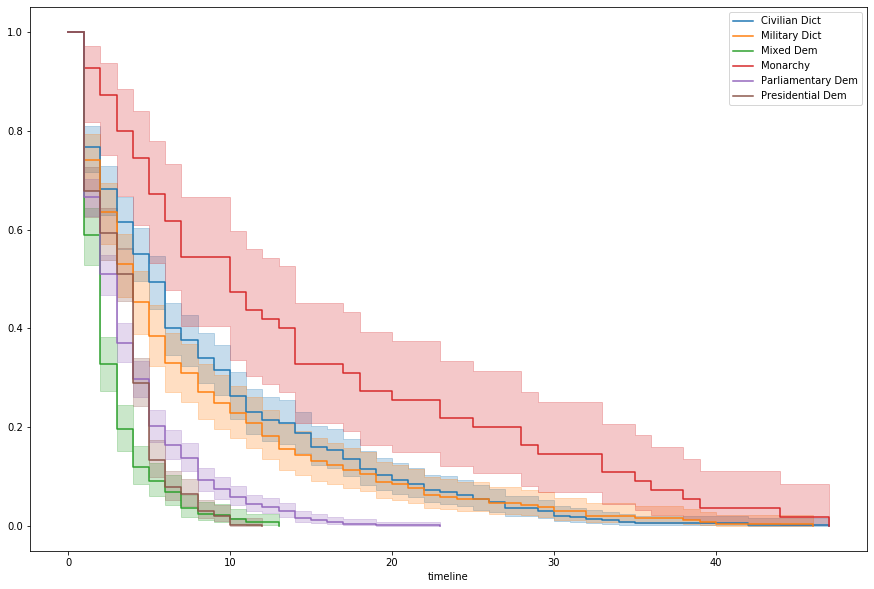

In [20]:
%pylab inline

from lifelines import KaplanMeierFitter

fig, ax = plt.subplots(figsize=(15, 10))

kmf = KaplanMeierFitter()

for idx, group in data.groupby('regime'):
    kmf.fit(group['duration'])
    kmf.plot(ax=ax, label=idx)

We'll use this to make a simple categorical binning

In [21]:
regime_mapping = {
    'Monarchy': 'Monarchy',
    'Civilian Dict': 'Dict',
    'Military Dict': 'Dict',
    'Parliamentary Dem': 'Dem',
    'Presidential Dem': 'Dem',
    'Mixed Dem': 'Dem'
}

data['regime_type'] = data['regime'].map(regime_mapping)

Probably also worth looking at this by continent, it seems

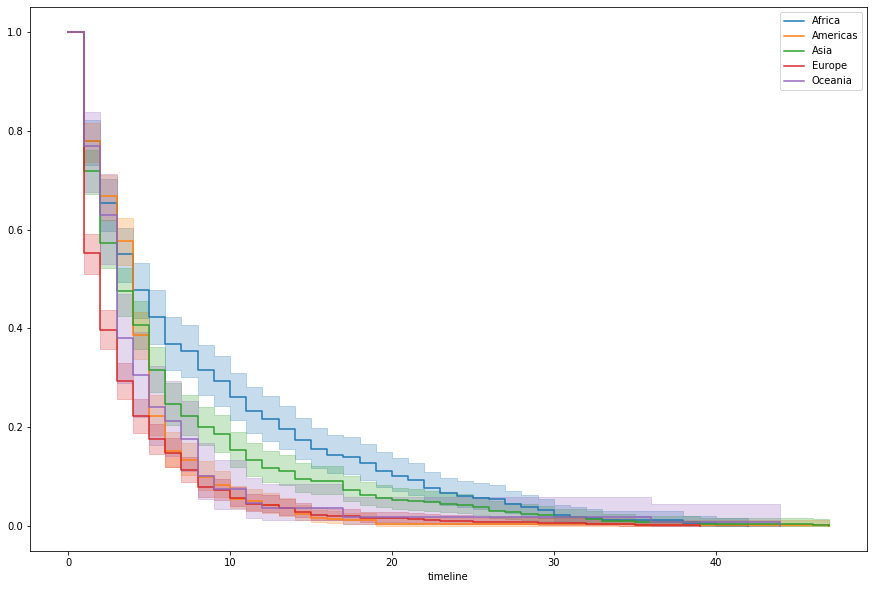

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))

kmf = KaplanMeierFitter()

for idx, group in data.groupby('un_continent_name'):
    kmf.fit(group['duration'])
    kmf.plot(ax=ax, label=idx, ci_show=True)

Finally, let's do our favorite year-to-decade `pandas` trick for good measure.

In [23]:
data['decade'] = data['start_year'] // 10 * 10

We'll lop off the other fields, dummy out the categorical features, and

In [24]:
trimmed = data[['un_continent_name', 'decade', 'duration', 'regime_type', 'observed']]

trimmed = pd.get_dummies(trimmed, drop_first=True)

trimmed.head()

,decade,duration,observed,un_continent_name_Americas,un_continent_name_Asia,un_continent_name_Europe,un_continent_name_Oceania,regime_type_Dict,regime_type_Monarchy
0,1940,7,1,0,1,0,0,0,1
1,1950,10,1,0,1,0,0,1,0
2,1960,10,1,0,1,0,0,0,1
3,1970,5,0,0,1,0,0,1,0
4,1970,1,0,0,1,0,0,1,0


Fitting a Cox model to it, we've got a concordance score of `0.64`. Not awful. We barely tried, so better-than-random using like two features is good enough for me on this one.

In [25]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.001)
cph.fit(trimmed, 'duration', 'observed')

cph.print_summary()

### Distribution shape

We can use the base hazard function of the Cox model to math our way to the base survival function

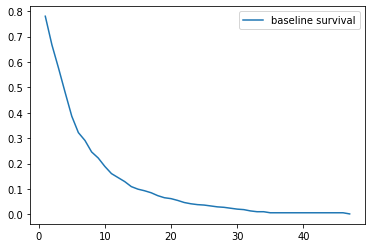

In [26]:
cph.baseline_survival_.plot();

Investigating, it looks like it *sort of* fits the right shape. Looks like it doesn't drop off fast enough, though.

The actual durations, for reference:

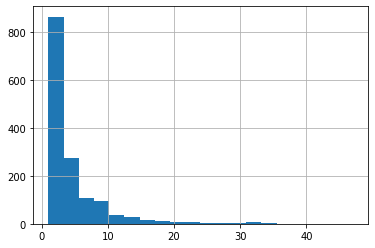

In [27]:
trimmed[trimmed['observed'] == True]['duration'].hist(bins=20);

### Expectations

The Expectation of the model has an important interpretation in this context-- the predicted churn/death of a given record.

Taking the expectation of all of our trimmed data, we can see a spike at the `10-15` range, which matches our "not dropping off fast enough" interpretation.

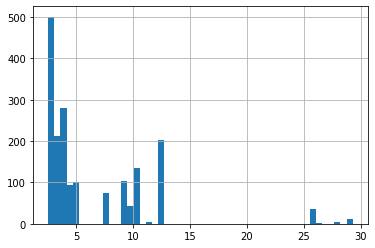

In [28]:
cph.predict_expectation(trimmed).hist(bins=50);

But what about concordance?

Maybe our curve shape doesn't completely align with reality, but this is the Cox *Proportional Hazard* model. We're more interested in how well we've captured the relationship between records' relative risk, and by extension their ordering in terms of survival.

We'll store this as a standalone `Series` for our analysis.

In [29]:
expectations = cph.predict_expectation(trimmed)

For example, it's relatively straight-forward for us to look at the performance of the concordance index, by continent (with the sample size printed, for context).

In [30]:
for idx, group in data.groupby('un_continent_name'):
    continent= data.loc[group.index]
    preds = expectations.loc[group.index]
    
    ci = concordance_index(continent['duration'],
                           preds,
                           continent['observed'])
    
    print(idx.ljust(10),
          f'{ci:.3f}',
          len(group))

Africa     0.608 314
Americas   0.476 412
Asia       0.682 398
Europe     0.549 576
Oceania    0.516 108


To the degree that we're doing a decent job at predicting death orders, it looks like our Asia and Africa results are propping up poor predictions elsewhere-- worse than random (`.5`) in the Americas.

### Time?

Curiously, though, this isn't to say that our model isn't doing *something* right.

If we now consider that "time-to-death" is a continuous variable, we can look at a more-traditional measure of model fit and investigate the Mean Squared Error by continent (with concordance left in, for context)

In [31]:
from sklearn.metrics import mean_squared_error

print(' '*10, 'CI'.ljust(5),
      'MSE'.ljust(6), 'Count')

for idx, group in data.groupby('un_continent_name'):
    continent= data.loc[group.index]
    preds = expectations.loc[group.index]
    
    ci = concordance_index(continent['duration'],
                           preds,
                           continent['observed'])
    
    mse = mean_squared_error(continent['duration'], 
                             preds)
    
    print(idx.ljust(10),
          f'{ci:.3f}',
          f'{mse:.3f}',
          len(group))

           CI    MSE    Count
Africa     0.608 74.030 314
Americas   0.476 28.611 412
Asia       0.682 53.970 398
Europe     0.549 18.923 576
Oceania    0.516 33.182 108


Hey, look at that-- despite poor Concordance scores in the Americas and Europe, our MSE outperforms Asia and Africa, where we were celebrating model fit just a second ago.

Chasing down where we're underperforming by *both* metrics can lead to discovery and creation of better variables. So let's pare down our dataset to records where we have observed values and dig in.

In [32]:
observed = data[data['observed'] == True]

To visualize patterns in our MSE, let's look at the raw difference between our predicted and observed deaths. This can be done in a couple of ways.

Looking at this in terms of volume, we might make a note to see if there's a commonality between Africa and Asia that we can use to rein in the kurtosis.

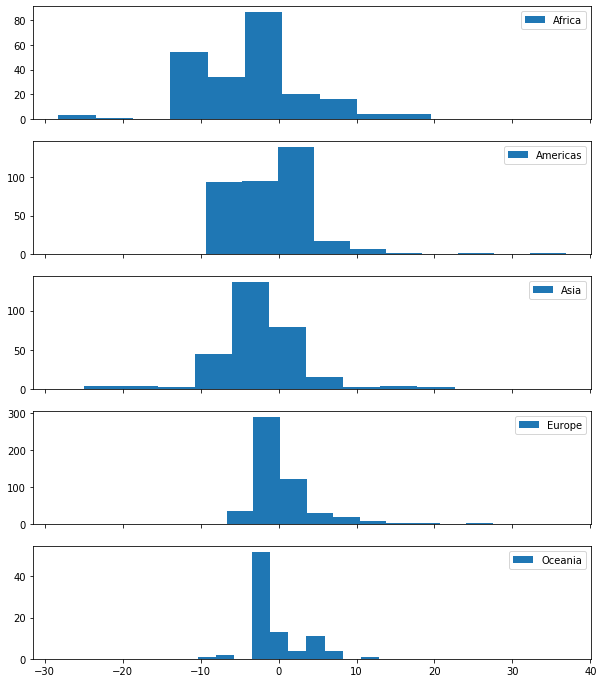

In [33]:
fig, axes = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

observed = data[data['observed'] == True]

for (idx, group), ax in zip(observed.groupby('un_continent_name'), axes.ravel()):
    ax.hist(group['duration'] - expectations.loc[group.index], label=idx)
    ax.legend()

Or with some simple box plots, we better-see the skew behavior

* Asia and Africa have outliers on both sides
* Americas and Europe have longer-tailed errors

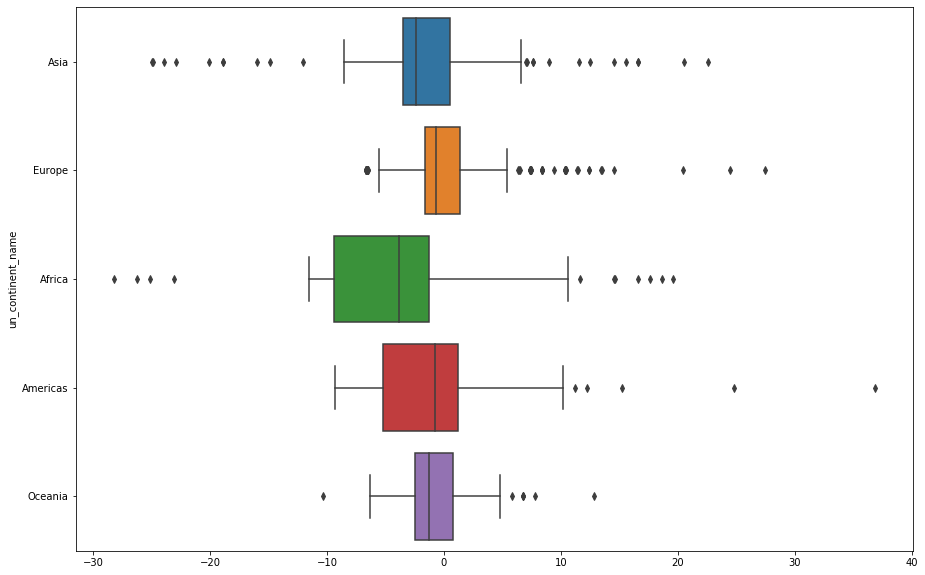

In [34]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 10))

sns.boxplot(y=observed['un_continent_name'],
            x=(data['duration'] - expectations),
            ax=ax);

Americas looks particularly offensive. Filtering down to just that continent and whipping up some KM curves by `region`, we can see that there's a pretty marked difference in the Caribbean.

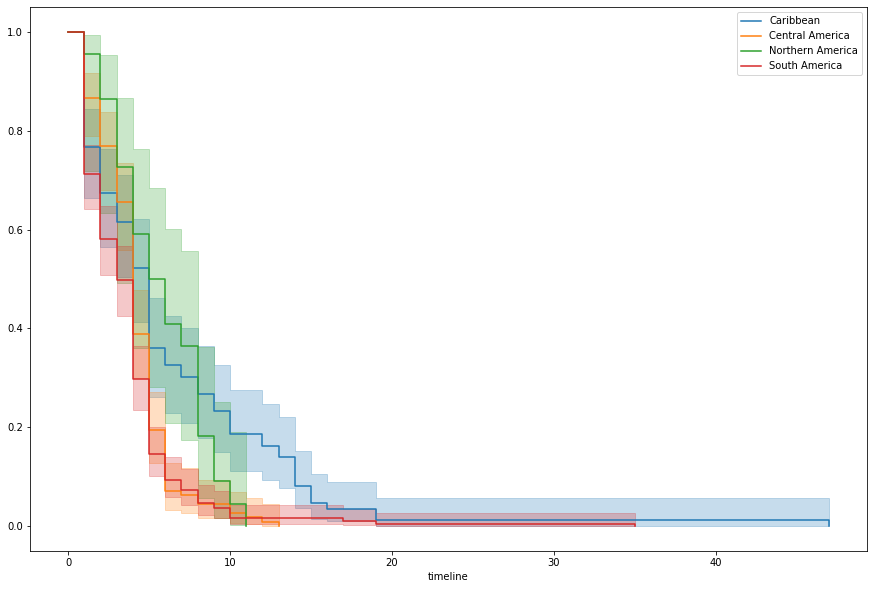

In [35]:
fig, ax = plt.subplots(figsize=(15, 10))

kmf = KaplanMeierFitter()

americas = data[data['un_continent_name'] == 'Americas']
for idx, group in americas.groupby('un_region_name'):
    kmf.fit(group['duration'])
    kmf.plot(ax=ax, label=idx, ci_show=True)

Which is the result of some serious outlier behavior.

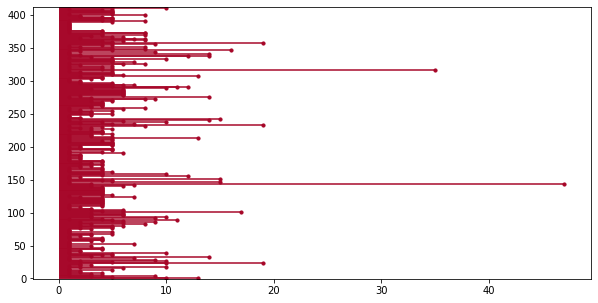

In [36]:
from lifelines.plotting import plot_lifetimes
from warnings import filterwarnings

fig, ax = plt.subplots(figsize=(10, 5))
filterwarnings('ignore')
plot_lifetimes(americas['duration'].reset_index(drop=True),
               ax=ax);

Now who could that be?

In [37]:
americas.loc[americas['duration'].idxmax()]

ctryname                                                      Cuba
cowcode2                                                        40
politycode                                                      40
un_region_name                                           Caribbean
un_continent_name                                         Americas
ehead                                             Fidel Castro Ruz
leaderspellreg       Fidel Castro Ruz.Cuba.1959.2005.Civilian Dict
democracy                                            Non-democracy
regime                                               Civilian Dict
start_year                                                    1959
duration                                                        47
observed                                                         1
regime_type                                                   Dict
decade                                                        1950
Name: 375, dtype: object

Egads

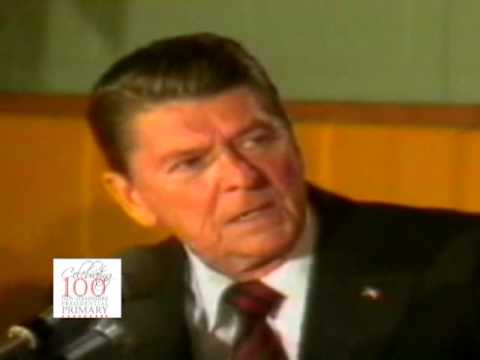

In [38]:
from IPython.display import Image
Image('images/rawhide.jpg')

### Now Wait a Minute

Of course, it's worth noting that if we wanted a model that scored well in terms of MSE, we should have trained on MSE.

To restate a notion we had above, the Cox Proportional Hazard model is designed to optimize how we stack rank records by their hazard. Full stop.

If we were instead interested in accuracy of survival prediction, it'd be more appropriate to use a method that duration as a target. Which, of course, then undervalues sorting and concordance.

It's all about defining the right objective for your application and picking the appropriate model. The same author as the top of this notebook has [a great notebook exploring this idea.](https://medium.com/analytics-vidhya/churn-prediction-in-a-telco-70ba5aa12f70)